<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Solar_Panel_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solar Energy Prediction using Linear Regression

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

#Using high resolution values

In [2]:
from google.colab import files
uploaded = files.upload() #Load 80929.csv or other 5 minute resolution files

Saving 80929.csv to 80929.csv


In [3]:
data_path = '/content/80929.csv'
df = pd.read_csv(data_path, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame
df

,Date,Power (kW)
0,9/30/2014 8:50,0.0
1,9/30/2014 8:55,1032.0
2,9/30/2014 9:00,1082.5
3,9/30/2014 9:05,1094.5
4,9/30/2014 9:10,1175.5
...,...,...
302423,6/4/2020 19:48,1.5
302424,6/4/2020 19:53,0.0
302425,6/4/2020 19:56,0.0
302426,6/4/2020 20:01,0.0


In [4]:
df_y = df.drop(columns=['Date'])
df_y

,Power (kW)
0,0.0
1,1032.0
2,1082.5
3,1094.5
4,1175.5
...,...
302423,1.5
302424,0.0
302425,0.0
302426,0.0


In [5]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
y = df_y.to_numpy()

#Create an input vector of just the values between 0 and 302,427
X = np.linspace(0, y.shape[0], y.shape[0])


Now that we have the data loaded, we can try performing a regression on it.

Text(0.5, 1.0, "('Energy usage at five minute intervals for ', 10, ' days.')")

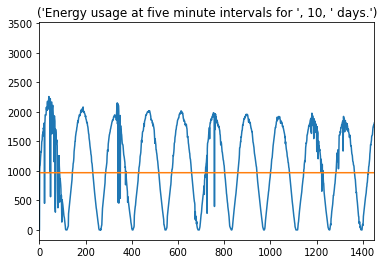

In [34]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True) #The fit_intercept=True means that 
                                             #we are not assuming the data is 
                                             #pre-centered
model.fit(X[:, np.newaxis], y) #The np.newaxis is required here because when x 
                               #was created, it was 1d: shape = (50,). Model.fit 
                               #requires 2d data. New shape = (50,1)

y_hat = model.predict(X[:, np.newaxis])

days_to_show = 10

plt.plot(X, y)
plt.plot(X, y_hat);
plt.xlim(0, days_to_show*145)
title = 'Energy usage at five minute intervals for ', days_to_show, ' days.'
plt.title(title)

Let's see what the equation of this prediction line is.

In [23]:
coefficients = model.coef_
slope = coefficients[0][0]

#Percent degredation over time
degredation = str(round(slope * 100, 3))
print("Solar panel degredation per day over time = ", degredation, "%")
degredation_per_year = str(round(slope * 100 * 364, 3))
print("Solar panel degredation per year over time = ", degredation_per_year, "%")

Solar panel degredation per day over time =  -0.006 %
Solar panel degredation per year over time =  -2.088 %


As we can see, this regression doesn't work well.  We could add polynomial features, but as this curve will be sinusoidal and will extend every day for many years, no amount of polynomial features will be effective.

A neural net regression algorithm is much more likely to be effective here.  But first, let's try and find a way to use linear regression to predict something useful.  Instead of trying to predict the power produced every five minutes throughout the day, what if we tried to predict the total power for each day.  To do this, we're going to load the total power data into Colab.

#Using Daily Values

In [17]:
from google.colab import files
uploaded = files.upload() #Load 80929_energy_per_day.csv or other daily total energy summaries

Saving 80929_energy_per_day.csv to 80929_energy_per_day.csv


In [18]:
data_path_totals = '/content/80929_energy_per_day.csv'
df = pd.read_csv(data_path_totals, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame
df

,12.53341667
0,14.201500
1,13.026417
2,13.852000
3,13.651958
4,12.996625
...,...
2069,19.063875
2070,18.135750
2071,16.941333
2072,18.265833


Text(0.5, 1.0, "('Energy daily totals for ', 60, ' days.')")

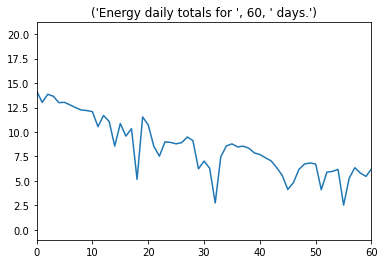

In [40]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
y_totals = df.to_numpy()

#Create an input vector of just the values between 0 and 302,427
X_totals = np.linspace(0, y_totals.shape[0], y_totals.shape[0])

days_to_show_total = 60

plt.plot(X_totals, y_totals)
plt.xlim(0, days_to_show_total)

title = 'Energy daily totals for ', days_to_show_total, ' days.'
plt.title(title)

Lets use a linear regression over a local area that won't change too much over time and will hopefully be close to linear.

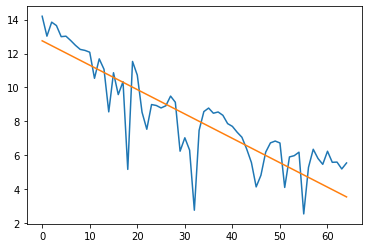

In [83]:

days_to_learn = days_to_show_total
days_to_predict = 5

X_local_totals_train = X_totals[:days_to_learn]
y_local_totals_train = y_totals[:days_to_learn]

X_local_totals_test = X_totals[:days_to_learn + days_to_predict]
y_local_totals_test = y_totals[:days_to_learn + days_to_predict]

model.fit(X_local_totals_train[:, np.newaxis], y_local_totals_train) 
y_local_totals_hat = model.predict(X_local_totals_test[:, np.newaxis])

days_to_show = days_to_learn + days_to_predict

plt.plot(X_local_totals_test, y_local_totals_test)
plt.plot(X_local_totals_test, y_local_totals_hat);

What if we add some polynomial features?

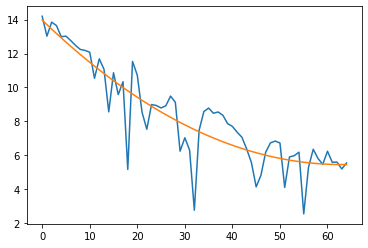

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Once we have the best polynomial order determined, we can use regression
poly_model_totals = make_pipeline(PolynomialFeatures(2), LinearRegression())    
poly_model_totals.fit(X_local_totals_train[:, np.newaxis], y_local_totals_train)  

#Now we predict into the future
y_local_totals_poly_hat = poly_model_totals.predict(X_local_totals_test[:, np.newaxis])

#Plot it
plt.plot(X_local_totals_test, y_local_totals_test)
plt.plot(X_local_totals_test, y_local_totals_poly_hat);


In [86]:
from sklearn.metrics import mean_squared_error

MSE_val = mean_squared_error(y_local_totals_test, y_local_totals_poly_hat)
print('MSE for Validation = ', MSE_val)

prediction = y_local_totals_poly_hat[-days_to_predict-1:-1]
real = y_local_totals_test[-days_to_predict-1:-1]

print('Predicted values: \n', prediction)
print('Real values: \n', real)

MSE for Validation =  1.6402625684194285
Predicted values: 
 [[5.48479105]
 [5.4695864 ]
 [5.45867211]
 [5.45204816]
 [5.44971456]]
Real values: 
 [[5.46254167]
 [6.23629167]
 [5.58283333]
 [5.59591667]
 [5.19083333]]
